__scrapes play by play and boxscore html tables from espn NBA basketball game websites, computes player to player and single player metrics amenable to network level visualizations and analyses__

- node features include time in game, points, player efficiency
- edge features include time any two players are in game together efficiency (points for minus points against) when two players are in game

- easy to implement other player features from boxscore or other sources if desired
- this script is a prototype-> I envision the average across the entire season or segments of the season and changes in network structure to be informative of team "connectivity"

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import networkx as nx
import nxviz as nv
from joblib import Parallel,delayed
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_html(url):
    '''Get the html of a url (str) in the format of 
    BeautifulSoup'''
    r = requests.get(url)
    html_doc = r.text
    soup = BeautifulSoup(html_doc,'lxml')
    return soup

In [3]:
def format_quarter_df(html):
    '''converts an html table into pandas df
    with an identifier (e.g., quarter) and 
    row information
    '''
    def get_contents(class_str):
        '''extracts contents 
        (or source dir of png image if team identifier) 
        from each row of playbyplay table
        based on class css keyword string
        '''
        data=[x['src'] if class_str=='team-logo' else x.contents[0] 
              for x in html.find_all(class_=class_str)]
        return data
    data={'id':html['id'],
          'team':get_contents('team-logo'),
          'score':get_contents('combined-score'),
          'event':get_contents('game-details'),
          'time':get_contents('time-stamp')}
    return pd.DataFrame(data)

In [4]:
def compute_sec_left(time_str):
    '''computes the seconds left from a given 
    digital time string (min:sec) shown (e.g., '11:45')
    '''
    seconds=[float(x) for x in time_str.split(':')]
    if len(seconds)>1:
        return seconds[0]*60+seconds[1]
    else:
        return seconds[0]

In [5]:
# get playbyplay info from html and put into pandas df
game_url='http://www.espn.com/nba/playbyplay?gameId='+'400974800'
game_html=get_html(game_url)
quarter_regex=re.compile('gp-quarter')
playbyplay_list=game_html.find_all(id=quarter_regex)
play_df=pd.concat([format_quarter_df(x) 
                      for x in playbyplay_list])

__calculate event time information__

In [6]:
#convert to seconds
play_df['sec_remain']=play_df['time'].apply(compute_sec_left)
#column of previous event time remaining
play_df['prev_sec_remain']=play_df.groupby(['id'])['sec_remain'].shift(1)
#time (in seconds) between last event and current event
play_df['time_elapsed']=play_df['prev_sec_remain']-play_df['sec_remain']
#cumulative time elapsed (by adding time in between all events)
play_df['cum_time_elapsed']=play_df['time_elapsed'].cumsum()

__format play by play data frame (`play_df`) to allow matching of player names in roster dataframe (`roster_df`)__

In [7]:
play_df['team']=(play_df['team']
                 .apply(lambda x:re.sub('.png.*','',
                                        x.split('/')[-1])))
play_df['event']=play_df['event'].str.lower()

__get roster lists from team boxscore modules html (outpute `roster_df`)__

In [8]:
boxscore_url='http://www.espn.com/nba/boxscore?gameId='+'400974800'
#espn puts the boxscore tables of each team's roster in separate 
#data-modules called boxscore. 
boxscore_html=(get_html(boxscore_url)
               .find('div',{'data-module':'boxscore'}))
#boxscores are organized such that there is:
#table header lines with type of player (starter or bench)
#table data line below these headers with names of players for that type 
boxscore_list=boxscore_html(re.compile('div|th|td'),
                            class_=re.compile('name'))
roster_list=[]
for tag in boxscore_list: #go through lines(headers and data)
    #for player and team, need to extract last part
    #of hyperlink to match up with play by play text
    if tag.name=='div':
        team=tag.find('img')['src'].split('/')[-1]
    elif tag.name=='th':
        player_type=tag.contents[0]
    elif tag.find('a'):
        player=tag.find('a')['href'].split('/')[-1]
        roster_list.append({'team':re.sub('.png.*','',team),
                            'player_type':player_type,
                            'player':player.replace('-',' ')})
roster_df=pd.DataFrame(roster_list)

In [9]:
#initiate the dataframe of players in game and
#list tracking players in game for each event
players_ingame=roster_df.query("player_type=='Starters'").copy()
players_ingame_list=[]
#go through each play
for i,play in play_df.iterrows():
    if 'enters the game' in play['event']:
        #if event is a substitution:
        ##replace player leaving game with player entering game
        entering_game=re.sub(' enters.*','',play['event'])
        leaving_game=re.sub('.*enters the game for ','',play['event'])
        ingame_loc=players_ingame['player']==leaving_game
        roster_loc=roster_df['player']==entering_game
        players_ingame.loc[ingame_loc]=(
            roster_df.loc[roster_loc].values)
    #append this new dataframe of players in game to a list
    players_ingame_list.append(players_ingame.copy())
#make a nested dataframe of players in game
play_df['players_ingame']=players_ingame_list

__extract points from event if made basket__

In [10]:
points_list=[]
for play in play_df['event']:
    if 'makes' in play:
        if 'three point' in play:
            points=3
        elif 'free throw' in play:
            points=1
        else:
            points=2
    else:
        points=np.nan
    points_list.append(points)
play_df['points']=points_list

__players involved in made basket (assist or point scored)__

In [11]:
#player1 --> player2 assist
#player1 --> player1 if no assist
play_players_list=[]
for play in play_df['event']:
    if 'makes' in play:
        players=re.findall('|'.join(roster_df['player']),play)
        if len(players)==1: #if no assist
            players=players+players
    else:
        players=['','']
    play_players_list.append(players)
play_df['players_involved_inplay']=play_players_list

make each stoppage of play end with players entering game so any dead ball events are attributed to people last in game e.g., free throws

In [12]:
play_df['enters_bool']=play_df['event'].str.contains('enters')
play_df=(play_df.groupby(['cum_time_elapsed'])
 .apply(lambda x: x.sort_values('enters_bool')))

__make df of all possible edges__

In [48]:
edge_list=[{'team':team,'players':[player1,player2]}
         for team,roster in roster_df.groupby('team')
         for i,player1 in enumerate(roster['player'])
         for player2 in roster['player'].iloc[i:]]
edge_df=pd.DataFrame(edge_list)         

In [49]:
#edge functions
def filter_ingame_df(player1,player2):
    '''filter play by play df for all events
    that have two specified players
    '''
    ingame_bool=(play_df['players_ingame']
                 .apply(lambda x: (x['player']==player1).any() & 
                        (x['player']==player2).any()))
    return play_df.loc[ingame_bool,:].copy()

def filter_assists(player1,player2):
    '''filter plays that involve both players involved in a play
    (either receiving or giving assists--undirected graph)
    '''
    assists_bool=(play_df['players_involved_inplay']
                 .apply(lambda x: (player1 in x) & 
                        (player2 in x)))
    return play_df.loc[assists_bool,:].copy()

def calc_edge_metrics(team,player1,player2):
    '''calculate total efficiency for when two
    players are in the game together
    '''
    df_filt=filter_ingame_df(player1,player2)
    off_re="team=='{}'"
    def_re="team!='{}'"
    offense_eff=df_filt.query(off_re.format(team))['points'].sum()
    defense_eff=df_filt.query(def_re.format(team))['points'].sum()
    assists=filter_assists(player1,player2)['points'].sum()
    time_ingame=df_filt['time_elapsed'].sum()
    return [team,player1,player2, assists, time_ingame,
            offense_eff-defense_eff,offense_eff,defense_eff]

__make df of undirected edge metrics__
- iterates through the possible edges (player-player combo)
- gets total metrics for that player-player combo from play by play df.

In [50]:
edge_metrics_list=Parallel(5)(delayed(calc_edge_metrics)
                 (team=edge['team'],
                  player1=edge['players'][0],
                  player2=edge['players'][1])
                 for i,edge in edge_df.iterrows())

In [51]:
edge_metrics_df=pd.DataFrame(edge_metrics_list,
                             columns=['team','player1','player2',
                                      'assists','time_ingame',
                                      'eff','off_eff','def_eff'])

In [103]:
def norm_cols(df,cols,amax=1,amin=0):
    '''normalize (default of max 1 and min 0)
    or specify different max, min for pd columns
    (uses sklearn util MinMaxScaler)'''
    df_copy=df.copy()
    norm=MinMaxScaler(feature_range=(amin,amax))
    norm_metrics=norm.fit_transform(df_copy[cols])
    df_copy[cols]=norm_metrics
    return df_copy

__edge and node dataframes to be inputted into networkx graph__

- node stats merges roster df with computed single player metrics and applies min and max for these metric columns that make sense for networkx visualizations
- edge stats filters out single player stats (as these are applied to node features) applies min and max that makes sense for networkx viz
- _here the viz parameters are specified such as color and size of edges and/or nodes_

In [164]:
metric_cols=['time_ingame','eff','assists']
node_nx_df=(roster_df
         .merge(edge_metrics_df
                .query("player1==player2 & team=='chi'")
                .filter(['player1']+metric_cols),
                left_on='player',right_on='player1')
         .pipe(norm_cols,metric_cols,1000,100)
         .pipe(norm_cols,['eff'],5,0)
         .filter(regex='player|^eff|time|team|assist'))
teams=np.unique(node_nx_df['team'])
#node_nx_df['team_colors']=(
#    node_nx_df['team'].map({teams[0]:'r',teams[1]:'b'}))
node_nx_df['team_colors']='r'
node_nx_df['player_type_colors']=(
    node_nx_df['player_type'].map({'Starters':'r','Bench':'b'}))

edge_nx_df=(edge_metrics_df
         .query("player1!=player2 & team=='chi'")
         .pipe(norm_cols,metric_cols,5,0)
         .filter(regex='player|^eff|time|assist'))

__make a networkx graph with various interesting attributes__

In [165]:
edge_graph=nx.Graph()
for i,player in node_nx_df.iterrows():
    attr_names=['team','team_colors','player_type','player_type_colors']+metric_cols
    edge_graph.add_node(n=player['player'],
                       **{attr:player[attr] 
                          for attr in attr_names})

for i,edge in edge_nx_df.iterrows():
    attr_names=metric_cols
    edge_graph.add_edge(u=edge['player1'],v=edge['player2'],
                       **{attr:edge[attr] for attr in attr_names})

__draw the networkx vizs with interesting node and edge specific features__

In [166]:
def list_nodeattr(graph,attr):
    return np.array([x[attr] for n,x in graph.nodes(data=True)])
def list_edgeattr(graph,attr):
    return np.array([x[attr] for u,v,x in graph.edges(data=True)])

__shows starters in red, bench in blue, time in game as node size, and time any two players are in game together as edge line width__

- as expected, starters formed a module of larger weights (given that starters typically play much more (and as a single unit) then bench players

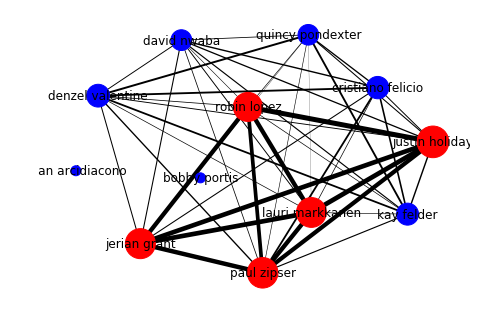

In [167]:
nx.draw_spring(edge_graph,
               weight='eff',
               width=list_edgeattr(edge_graph,'time_ingame'),
               node_color=list_nodeattr(edge_graph,'player_type_colors'),
               node_size=list_nodeattr(edge_graph,'time_ingame'),
               with_labels=True)

__shows starters in red, bench in blue, time in game as node size, and player to player assists (receiving or giving) as edge line width__

- this network shows the power of these types of analyses not available in boxscores--> prominently displayed are the guard- forward (e.g.,jerian grant- robin lopez) pattern of assists common in basketball rather than forward to forward (e.g., no paul zipser to robin lopez) 

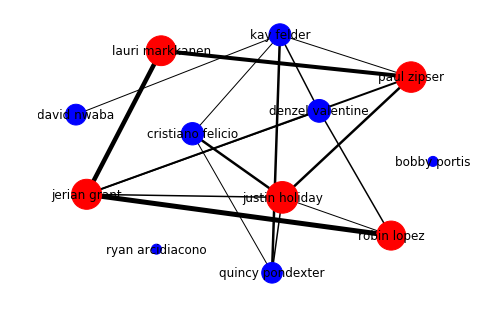

In [168]:
nx.draw_spring(edge_graph,
               weight='eff',
               width=list_edgeattr(edge_graph,'assists'),
               node_color=list_nodeattr(edge_graph,'player_type_colors'),
               node_size=list_nodeattr(edge_graph,'time_ingame'),
               with_labels=True)